In [2]:
import yaml
import pandas as pd
import os
os.chdir('../')
import logging

from src.database.manager import DatabaseManager
from src.preprocessing.database_preprocessing import DatabasePreprocessor
from src.utils.schema_reader import SchemaReader
import sys

import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.float_format = '{:.2f}'.format



# Configure logging
logging.basicConfig(level=logging.INFO)


def read_params_file(file_path):
    """
    Reads a YAML parameters file and returns the content as a dictionary.

    Args:
        file_path (str): The path to the YAML parameters file.

    Returns:
        dict: A dictionary containing the parameters read from the file.
    """
    with open(file_path) as yaml_file:
        params = yaml.safe_load(yaml_file)
    return params


def connect_to_database(params):
    """
    Connects to the database using the provided parameters.

    Args:
        params (dict): Database connection parameters.

    Returns:
        DatabaseManager: An instance of DatabaseManager representing the database connection.
    """
    db_manager = DatabaseManager(dbname=params['database']['config']['dbname'],
                                 host=params['database']['config']['host'],
                                 user=params['database']['config']['user'],
                                 port=params['database']['config']['port'],
                                 password=params['database']['config']['password'])

    return db_manager



In [2]:

params = read_params_file(os.path.join('config', 'params.yaml'))

# Connect to the database
db_manager = connect_to_database(params)

# Process training dataset
########################################################################
train_table_name = params['database']['train_table_name']

In [3]:
df = db_manager.select_from_table(table_name=train_table_name ,
                             schema_file_path=params['schemas']['training_schema_path'])

#### Converting target to binary

In [4]:
df['"y"']

0         no
1         no
2        yes
3         no
4         no
        ... 
32945     no
32946     no
32947     no
32948     no
32949     no
Name: "y", Length: 32950, dtype: object

In [5]:
df['"y"'] = df['"y"'].map({'no': 0, 'yes': 1})


In [6]:
df['"y"']

0        0
1        0
2        1
3        0
4        0
        ..
32945    0
32946    0
32947    0
32948    0
32949    0
Name: "y", Length: 32950, dtype: int64

In [39]:
df['"age"'].describe()

count   32950.00
mean       40.01
std        10.40
min        17.00
25%        32.00
50%        38.00
75%        47.00
max        98.00
Name: "age", dtype: float64

#### Making age groups 

In [7]:
# Define the bin edges and labels
bins = [0, 18, 30, 40, 50, 60, 100]  # Adjust the bin edges according to your requirements
labels = ['0-18', '19-30', '31-40', '41-50', '51-60', '61+']  # Adjust the labels according to your preference

# Create a new column with the age groups
df['"age_group"'] = pd.cut(df['"age"'], bins=bins, labels=labels, right=False)

# Print the updated DataFrame
print(df.head())

   "age"         "job" "marital"        "education" "default" "housing"   
0     49   blue-collar   married           basic.9y   unknown        no  \
1     37  entrepreneur   married  university.degree        no        no   
2     78       retired   married           basic.4y        no        no   
3     36        admin.   married  university.degree        no       yes   
4     59       retired  divorced  university.degree        no        no   

  "loan"  "contact" "month" "day_of_week"  "duration"  "campaign"  "pdays"   
0     no   cellular     nov           wed         227           4      999  \
1     no  telephone     nov           wed         202           2      999   
2     no   cellular     jul           mon        1148           1      999   
3     no  telephone     may           mon         120           2      999   
4     no   cellular     jun           tue         368           2      999   

   "previous"   "poutcome"  "y" "age_group"  
0           0  nonexistent    0   

In [37]:
# Create a contingency table
contingency_table = pd.crosstab(df['"age_group"'], df['"y"'])

# Perform the chi-square test
chi2, p_val, dof, expected = chi2_contingency(contingency_table)

# Interpret the results
print("Chi-square statistic:", chi2)
print("P-value:", p_val)
print("Degrees of freedom:", dof)
print("Expected frequencies:", expected)

Chi-square statistic: 1009.4348065271199
P-value: 5.448075627988547e-216
Degrees of freedom: 5
Expected frequencies: [[2.66203338e+00 3.37966616e-01]
 [4.05605153e+03 5.14948467e+02]
 [1.19667274e+04 1.51927259e+03]
 [7.48031381e+03 9.49686191e+02]
 [4.89015533e+03 6.20844674e+02]
 [8.42089894e+02 1.06910106e+02]]


In [45]:
contingency_table

"""y""",0,1
"""age_group""",,
0-18,2,1
19-30,3817,754
31-40,12131,1355
41-50,7758,672
51-60,4957,554
61+,573,376


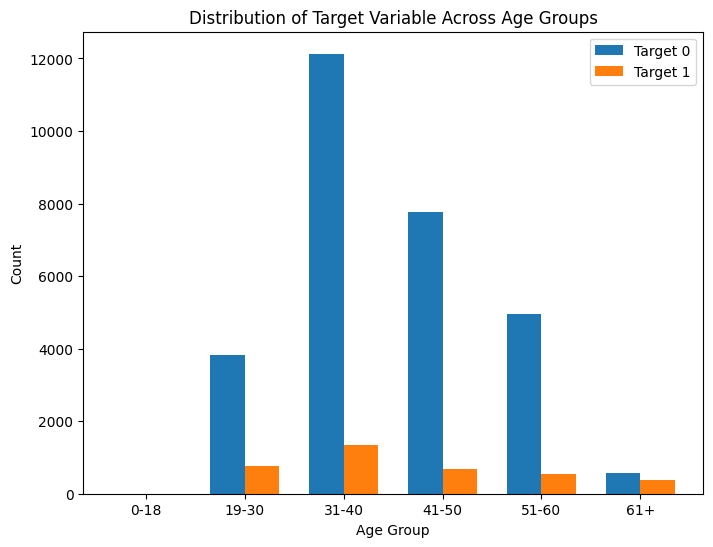

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Define the data
age_groups = ['0-18', '19-30', '31-40', '41-50', '51-60', '61+']
target_0 = [2, 3817, 12131, 7758, 4957, 573]
target_1 = [1, 754, 1355, 672, 554, 376]

# Set the width of the bars
bar_width = 0.35

# Set the x-axis positions for the bars
index = np.arange(len(age_groups))

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(index, target_0, width=bar_width, label='Target 0')
plt.bar(index + bar_width, target_1, width=bar_width, label='Target 1')

# Customize the plot
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Distribution of Target Variable Across Age Groups')
plt.xticks(index + bar_width / 2, age_groups)
plt.legend()

# Show the plot
plt.show()


C:\Users\amnassar\AppData\Local\Temp\ipykernel_19088\869807689.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.1f}%'.format(x) for x in plt.gca().get_yticks()])


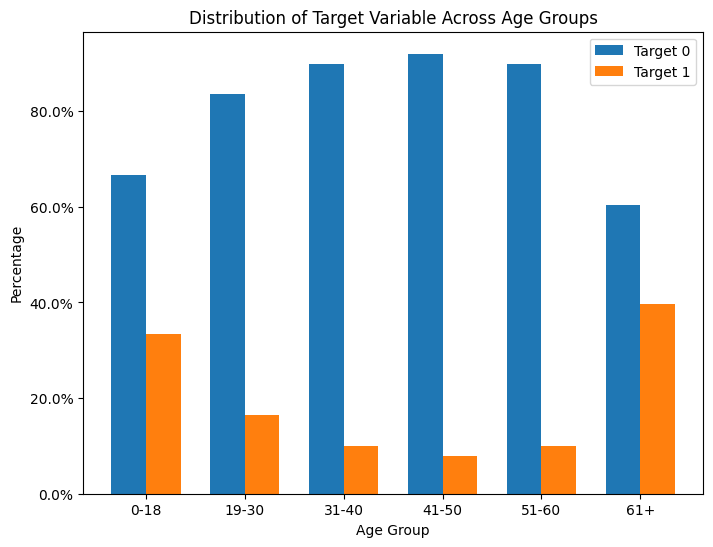

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Define the data
age_groups = ['0-18', '19-30', '31-40', '41-50', '51-60', '61+']
target_0 = [2, 3817, 12131, 7758, 4957, 573]
target_1 = [1, 754, 1355, 672, 554, 376]

# Calculate the total count for each age group
total_counts = [t0 + t1 for t0, t1 in zip(target_0, target_1)]

# Calculate the percentages
target_0_percent = [t0 / total * 100 for t0, total in zip(target_0, total_counts)]
target_1_percent = [t1 / total * 100 for t1, total in zip(target_1, total_counts)]

# Set the width of the bars
bar_width = 0.35

# Set the x-axis positions for the bars
index = np.arange(len(age_groups))

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(index, target_0_percent, width=bar_width, label='Target 0')
plt.bar(index + bar_width, target_1_percent, width=bar_width, label='Target 1')

# Customize the plot
plt.xlabel('Age Group')
plt.ylabel('Percentage')
plt.title('Distribution of Target Variable Across Age Groups')
plt.xticks(index + bar_width / 2, age_groups)
plt.legend()

# Update y-axis labels as percentages
plt.gca().set_yticklabels(['{:.1f}%'.format(x) for x in plt.gca().get_yticks()])

# Show the plot
plt.show()


We should create a flag that sees if that age is above 61 or below 18

In [38]:
contingency_table

"""y""",0,1
"""age_group""",,
0-18,2,1
19-30,3817,754
31-40,12131,1355
41-50,7758,672
51-60,4957,554
61+,573,376


In [8]:
# Assuming you have a DataFrame called 'df' containing your numerical columns
numerical_columns = ['"age"',  '"duration"', '"campaign"', '"pdays"', '"previous"' , '"y"']

# Calculate the correlation matrix
correlation_matrix = df[numerical_columns].corr()

# Print the correlation matrix
print(correlation_matrix['"y"'])


"age"         0.03
"duration"    0.40
"campaign"   -0.07
"pdays"      -0.33
"previous"    0.23
"y"           1.00
Name: "y", dtype: float64


In [16]:
pd.crosstab(df['"poutcome"'], df['"y"']) 

"""y""",0,1
"""poutcome""",,
failure,2935,494
nonexistent,25915,2501
success,388,717


In [27]:
# Create a contingency table
contingency_table = pd.crosstab(df['"poutcome"'], df['"y"'])

# Perform the chi-square test
chi2, p_val, dof, expected = chi2_contingency(contingency_table)

# Interpret the results
print("Chi-square statistic:", chi2)
print("P-value:", p_val)
print("Degrees of freedom:", dof)
print("Expected frequencies:", expected)

Chi-square statistic: 3384.73268697194
P-value: 0.0
Degrees of freedom: 2
Expected frequencies: [[ 3042.70415781   386.29584219]
 [25214.78021244  3201.21978756]
 [  980.51562974   124.48437026]]


- Since the expected frequencies differ from the observed frequencies in case of 'success' , we can make a flag if the poutcome is success or not

In [9]:
pd.crosstab(df['"job"'], df['"y"']) 

"""y""",0,1
"""job""",,
admin.,7244,1070
blue-collar,6926,515
entrepreneur,1060,100
housemaid,769,86
management,2076,269
retired,1018,348
self-employed,980,119
services,2942,254
student,494,217


In [28]:
# Create a contingency table
contingency_table = pd.crosstab(df['"job"'], df['"y"'])

# Perform the chi-square test
chi2, p_val, dof, expected = chi2_contingency(contingency_table)

# Interpret the results
print("Chi-square statistic:", chi2)
print("P-value:", p_val)
print("Degrees of freedom:", dof)
print("Expected frequencies:", expected)

Chi-square statistic: 756.3303578965546
P-value: 4.475532048476782e-155
Degrees of freedom: 11
Expected frequencies: [[7377.38185129  936.61814871]
 [6602.73013657  838.26986343]
 [1029.31957511  130.68042489]
 [ 758.67951442   96.32048558]
 [2080.82276176  264.17723824]
 [1212.11253414  153.88746586]
 [ 975.19156297  123.80843703]
 [2835.95289833  360.04710167]
 [ 630.90191199   80.09808801]
 [4791.66009105  608.33990895]
 [ 708.10088012   89.89911988]
 [ 235.14628225   29.85371775]]


In [30]:
pd.crosstab(df['"education"'], df['"y"']) 

"""y""",0,1
"""education""",,
basic.4y,2978,344
basic.6y,1709,156
basic.9y,4457,369
high.school,6781,815
illiterate,13,3
professional.course,3719,473
university.degree,8391,1345
unknown,1190,207


In [29]:
# Create a contingency table
contingency_table = pd.crosstab(df['"education"'], df['"y"'])

# Perform the chi-square test
chi2, p_val, dof, expected = chi2_contingency(contingency_table)

# Interpret the results
print("Chi-square statistic:", chi2)
print("P-value:", p_val)
print("Degrees of freedom:", dof)
print("Expected frequencies:", expected)

Chi-square statistic: 165.70316494240055
P-value: 2.0199151269942383e-32
Degrees of freedom: 7
Expected frequencies: [[2.94775830e+03 3.74241700e+02]
 [1.65489742e+03 2.10102580e+02]
 [4.28232437e+03 5.43675630e+02]
 [6.74026853e+03 8.55731472e+02]
 [1.41975114e+01 1.80248862e+00]
 [3.71974798e+03 4.72252018e+02]
 [8.63918568e+03 1.09681432e+03]
 [1.23962021e+03 1.57379788e+02]]


In [31]:
pd.crosstab(df['"marital"'], df['"y"']) 

"""y""",0,1
"""marital""",,
divorced,3304,371
married,17933,2020
single,7947,1310
unknown,54,11


In [32]:
# Create a contingency table
contingency_table = pd.crosstab(df['"marital"'], df['"y"'])

# Perform the chi-square test
chi2, p_val, dof, expected = chi2_contingency(contingency_table)

# Interpret the results
print("Chi-square statistic:", chi2)
print("P-value:", p_val)
print("Degrees of freedom:", dof)
print("Expected frequencies:", expected)

Chi-square statistic: 110.26062017522887
P-value: 9.643782010240503e-24
Degrees of freedom: 3
Expected frequencies: [[3.26099090e+03 4.14009105e+02]
 [1.77051840e+04 2.24781596e+03]
 [8.21414768e+03 1.04285232e+03]
 [5.76773900e+01 7.32261002e+00]]


In [33]:
pd.crosstab(df['"default"'], df['"y"']) 

"""y""",0,1
"""default""",,
no,22656,3351
unknown,6579,361
yes,3,0


In [34]:
# Create a contingency table
contingency_table = pd.crosstab(df['"default"'], df['"y"'])

# Perform the chi-square test
chi2, p_val, dof, expected = chi2_contingency(contingency_table)

# Interpret the results
print("Chi-square statistic:", chi2)
print("P-value:", p_val)
print("Degrees of freedom:", dof)
print("Expected frequencies:", expected)

Chi-square statistic: 323.88554163958065
P-value: 4.66818704286385e-71
Degrees of freedom: 2
Expected frequencies: [[2.30771674e+04 2.92983259e+03]
 [6.15817056e+03 7.81829439e+02]
 [2.66203338e+00 3.37966616e-01]]


In [23]:
pd.crosstab(df['"housing"'], df['"y"']) 

"""y""",0,1
"""housing""",,
no,13272,1628
unknown,706,90
yes,15260,1994


In [35]:
# Create a contingency table
contingency_table = pd.crosstab(df['"housing"'], df['"y"'])

# Perform the chi-square test
chi2, p_val, dof, expected = chi2_contingency(contingency_table)

# Interpret the results
print("Chi-square statistic:", chi2)
print("P-value:", p_val)
print("Degrees of freedom:", dof)
print("Expected frequencies:", expected)

Chi-square statistic: 3.18159141843302
P-value: 0.20376341078642682
Degrees of freedom: 2
Expected frequencies: [[13221.43247344  1678.56752656]
 [  706.3261912     89.6738088 ]
 [15310.24133536  1943.75866464]]


In [24]:
pd.crosstab(df['"loan"'], df['"y"']) 

"""y""",0,1
"""loan""",,
no,24073,3058
unknown,706,90
yes,4459,564


In [36]:
# Create a contingency table
contingency_table = pd.crosstab(df['"loan"'], df['"y"'])

# Perform the chi-square test
chi2, p_val, dof, expected = chi2_contingency(contingency_table)

# Interpret the results
print("Chi-square statistic:", chi2)
print("P-value:", p_val)
print("Degrees of freedom:", dof)
print("Expected frequencies:", expected)

Chi-square statistic: 0.009169655868587832
P-value: 0.9954256663450188
Degrees of freedom: 2
Expected frequencies: [[24074.54257967  3056.45742033]
 [  706.3261912     89.6738088 ]
 [ 4457.13122914   565.86877086]]
